# Observational Evidence of Intracluster Dust Evolution in Open Clusters

# 1.1 Clusters with age below 500 Myrs

## Imports

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

## open clusters dataset

In [2]:
open_clusters = pd.read_excel('../../data/open clusters table.xlsx')

In [3]:
oc = open_clusters[['Name', 'logt']].dropna(axis=0).drop(index=0)
oc['logt'] = oc.logt.astype(float)

In [4]:
oc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
logt,911.0,8.079481,0.768238,6.0,7.455,8.155,8.635,10.08


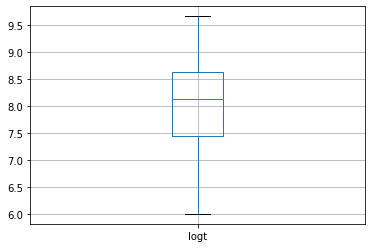

In [5]:
oc[10**oc['logt'] < 5 * 10**9].boxplot();

In [6]:
open_clusters = open_clusters.iloc[oc[10**oc['logt'] < .5 * 10**9].index].dropna(axis=1)

In [7]:
open_clusters

,Name,RA,DEC,l,b,logt,D
2,Alessi 2,04 46 15,+55 13 47,152.29,6.36,8.6,33.6
4,Alessi 5,10 43 08,-61 10 11,288.08,-2.05,7.71,36
5,Alessi 6,14 40 15,-66 07 12,313.64,-5.53,8.3,50.4
6,Alessi 8,15 29 34,-51 13 47,326.49,4.27,7.92,37.2
7,Alessi 9,17 43 55,-47 10 48,344.13,-9.13,8.42,168
...,...,...,...,...,...,...,...
960,vdB-Hagen 221,17 18 39,-32 20 24,353.97,3,8.01,27.6
961,vdB-Hagen 222,17 18 47,-38 17 00,349.13,-0.44,7.78,2
962,vdB-Hagen 245,17 46 16,-29 42 00,359.42,-0.52,7.17,1
967,Waterloo 6,08 40 24,-46 08 00,264.85,-2.66,7.671,2


In [8]:
open_clusters[open_clusters['Name'] == "NGC 6618"]

,Name,RA,DEC,l,b,logt,D
707,NGC 6618,18 20 47,-16 10 18,15.1,-0.75,6,25


-----

## Functions 

In [9]:
def preprocess_cluster(data, g_mean_th=18):
    """
    ------
    parallax > 0 

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,6), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();
        
        
def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        );
    
    
def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(12,3), dpi=120)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data)
    
    plt.figure(figsize=(12,3), dpi=120)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt


def guassian_filter(data, column, mu, std):    
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)
    
    if up > low:
        print('upper bound:', up) 
        print('lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print('upper bound:', low) 
        print('lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]
    
    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """    
    
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');

---------

## Young Clusters

### NGC 6618 (0.001 Myr)

```sql
SELECT gaia_source.source_id, gaia_source.ra ,
gaia_source.ra_error, gaia_source.dec ,
gaia_source.dec_error, gaia_source.parallax,
gaia_source.parallax_error, gaia_source.pmra,
gaia_source.pmdec, gaia_source.phot_g_mean_mag,
gaia_source.bp_rp, gaia_source.bp_g,
gaia_source.g_rp, gaia_source.radial_velocity,
gaia_source.radial_velocity_error, gaia_source.phot_variable_flag,
gaia_source.l, gaia_source.b,
dist.r_med_geo, dist.r_med_photogeo
FROM gaiadr3.gaia_source 
LEFT JOIN external.gaiaedr3_distance as dist on (gaia_source.source_id = dist.source_id )
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	CIRCLE(
		'ICRS',
		COORD1(EPOCH_PROP_POS(275.1958,-16.1717,.6000,1.5100,-1.7400,-44.5770,2000,2016.0)),
		COORD2(EPOCH_PROP_POS(275.1958,-16.1717,.6000,1.5100,-1.7400,-44.5770,2000,2016.0)),
		0.18333333333333332)
)=1

```

In [10]:
df_NGC_6618 = pd.read_csv('../../data/NGC 6618-result.csv')

In [11]:
df_NGC_6618 = preprocess_cluster(df_NGC_6618, g_mean_th=18)

1624


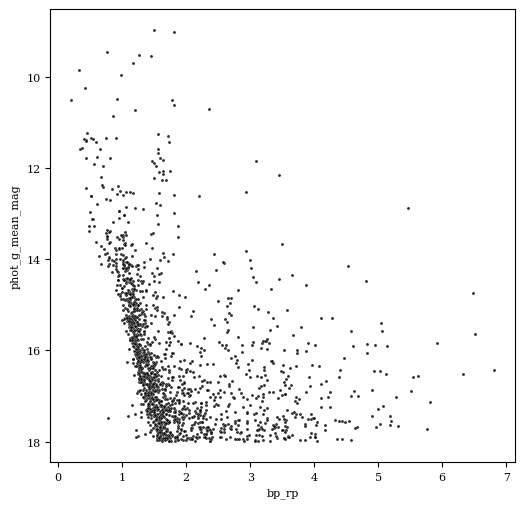

In [12]:
cmd_plot(df_NGC_6618, 'bp_rp', 'phot_g_mean_mag')

In [13]:
df_NGC_6618_new = df_NGC_6618.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)
len(df_NGC_6618_new)

1609

<Figure size 540x360 with 0 Axes>

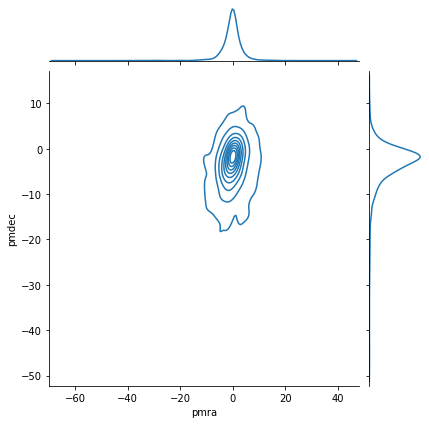

In [14]:
joint_plot(df_NGC_6618_new)

In [15]:
# Initial Filter on PMRA and PMDEC based on joint plot
df_NGC_6618_new = df_NGC_6618_new[abs(df_NGC_6618_new['pmra']) < 20]
df_NGC_6618_new = df_NGC_6618_new[abs(df_NGC_6618_new['pmdec']) < 20]
len(df_NGC_6618_new)

1578

<Figure size 540x360 with 0 Axes>

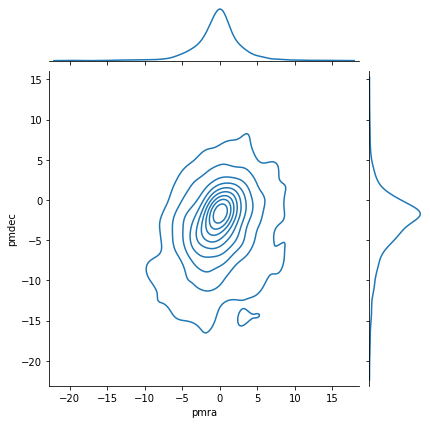

In [16]:
joint_plot(df_NGC_6618_new)

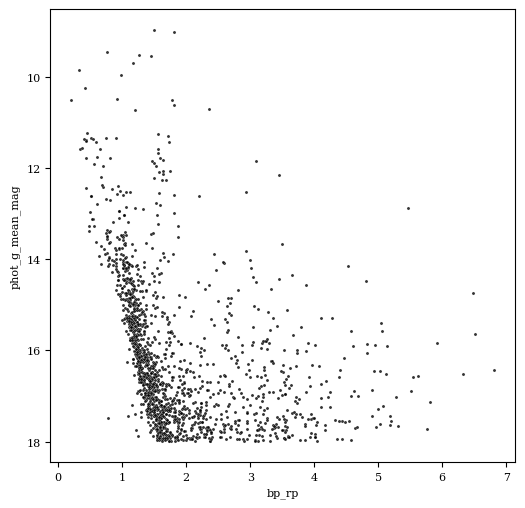

In [17]:
cmd_plot(df_NGC_6618_new, 'bp_rp', 'phot_g_mean_mag')

## Filters

**NGC 6618:**  

Proper motions mas/yr based on [SIMBAD](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=NGC+6618&submit=SIMBAD+search):	
```python
    pmra:   1.510
    pmdec: -1.740
```

In [18]:
df_NGC_6618_new = df_NGC_6618_new[abs(df_NGC_6618_new['pmra']-1.5)  < 3]
df_NGC_6618_new = df_NGC_6618_new[abs(df_NGC_6618_new['pmdec']+1.74) < 3]
df_NGC_6618_new = df_NGC_6618_new[abs(df_NGC_6618_new['parallax']-0.60) < 3]
len(df_NGC_6618_new)

838

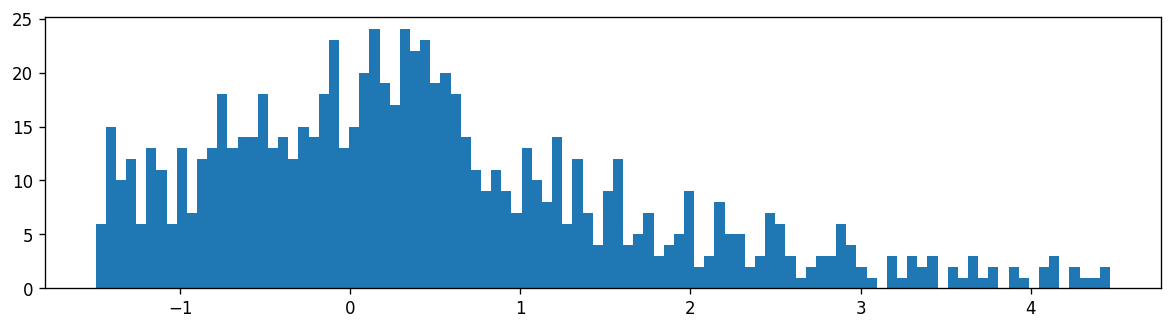

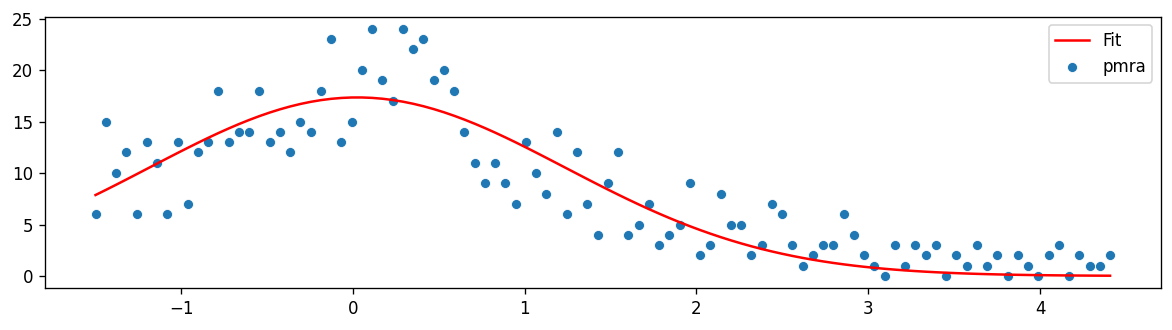

In [19]:
amp, mu, std = fit_curve(df_NGC_6618_new, 'pmra', bins=100)

In [20]:
df_NGC_6618_new = guassian_filter(df_NGC_6618_new, 'pmra', mu, std)

upper bound: 3.66
lower bound: -3.61
cluster length: 820


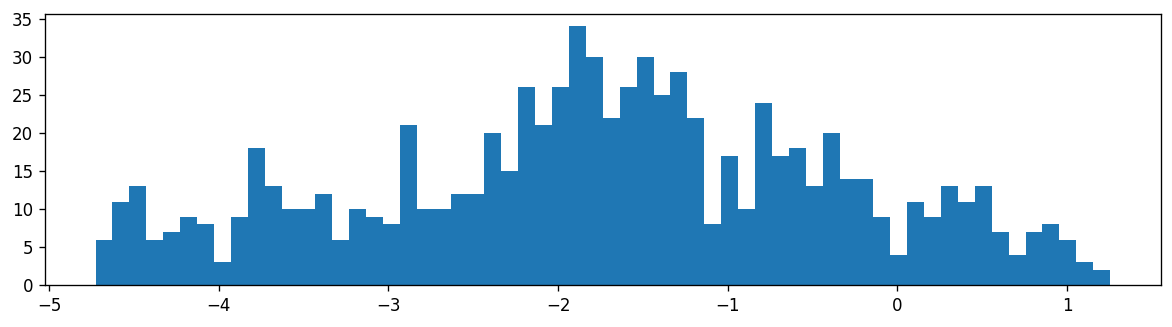

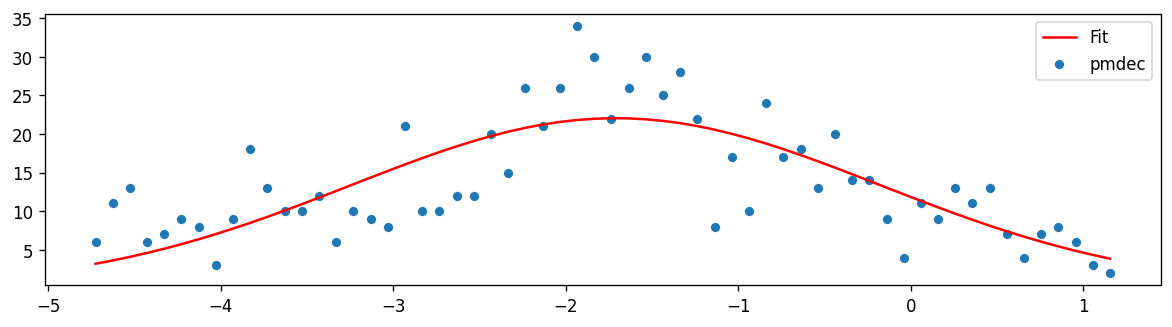

In [21]:
amp, mu, std = fit_curve(df_NGC_6618_new, 'pmdec', bins=60)

In [22]:
df_NGC_6618_new = guassian_filter(df_NGC_6618_new, 'pmdec', mu, std)

upper bound: 2.89
lower bound: -6.31
cluster length: 820


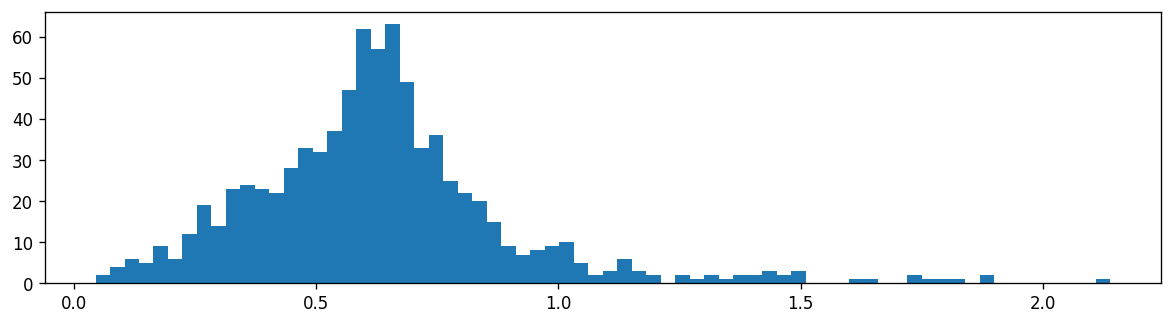

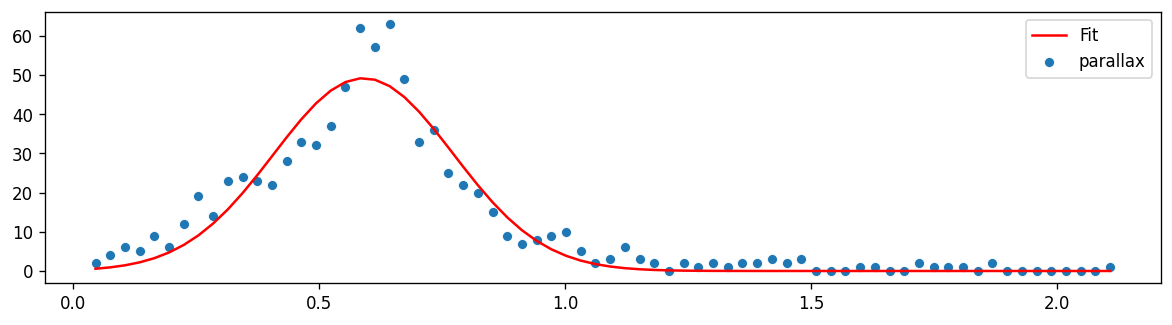

In [23]:
amp, mu, std = fit_curve(df_NGC_6618_new, 'parallax', bins=70)

In [24]:
df_NGC_6618_new = guassian_filter(df_NGC_6618_new, 'parallax', mu, std)

upper bound: 1.14
lower bound: 0.04
cluster length: 784


### GMM 

In [25]:
gm = GaussianMixture(n_components=2, random_state=0)

y_pred = gm.fit_predict(df_NGC_6618_new[['pmra', 'pmdec', 'parallax']])
y_prob = gm.predict_proba(df_NGC_6618_new[['pmra', 'pmdec', 'parallax']])
df_NGC_6618_new['cluster'] = y_pred
df_NGC_6618_new['prob'] = np.amax(y_prob,axis=1)

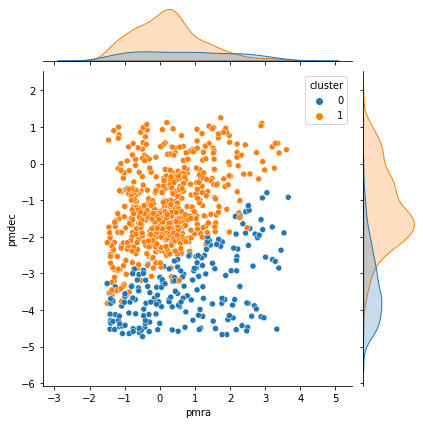

In [26]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_6618_new, kind='scatter', hue='cluster');

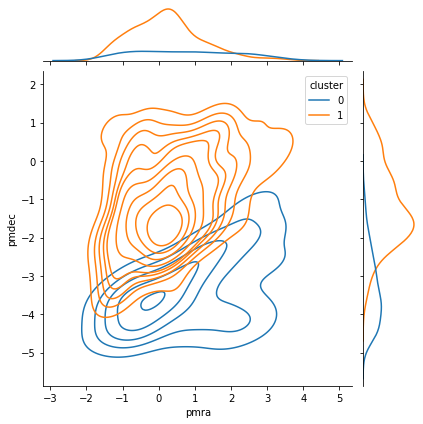

In [27]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_6618_new, kind='kde', hue='cluster');

---
---
---

In [37]:
cluster_NGC_6618 = df_NGC_6618_new[df_NGC_6618_new['cluster']==1]
len(cluster_NGC_6618)

578

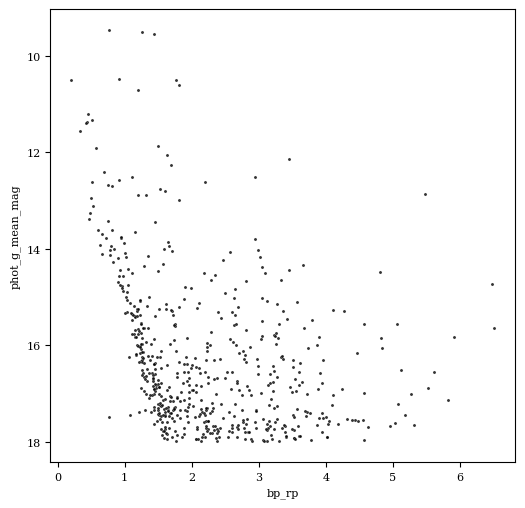

In [38]:
cmd_plot(cluster_NGC_6618, 'bp_rp', 'phot_g_mean_mag')

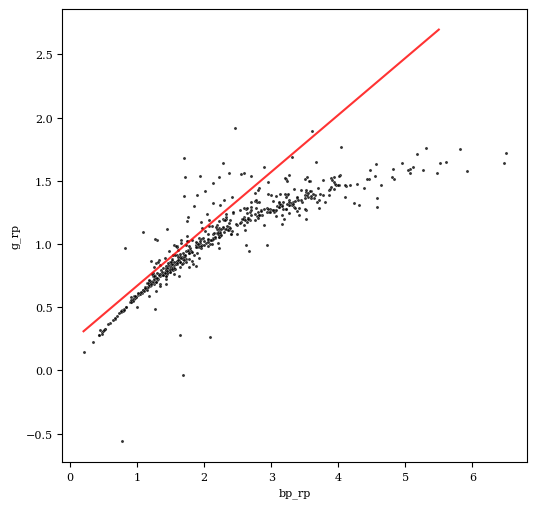

In [39]:
cmd_plot(cluster_NGC_6618, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0.2,5.5), (0.45 * np.linspace(0.2,5.5)) + 0.22, color='red', alpha=0.8)
plt.gca().invert_yaxis();

In [40]:
# Cluster Center based on SIMBAD
SkyCoord(l = 15.0953 , b = -.7454, unit='deg',  frame='galactic').icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (275.19589212, -16.17164067)>

<AxesSubplot:xlabel='ra', ylabel='dec'>

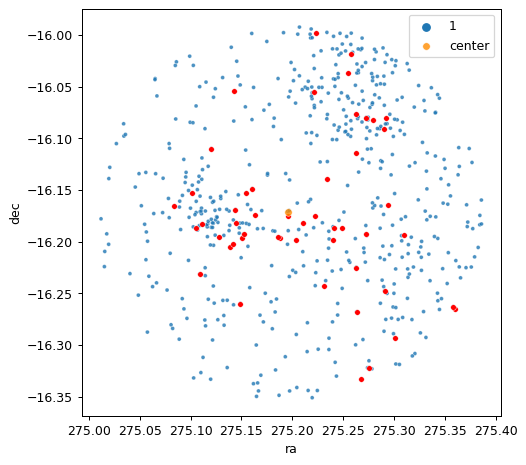

In [41]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = cluster_NGC_6618, x = 'ra', y='dec', alpha=0.8, s=10, hue='cluster')

sns.scatterplot(data = cluster_NGC_6618 [((cluster_NGC_6618['bp_rp'] * .45 ) + 0.22) <= cluster_NGC_6618['g_rp']],
                x = 'ra', y = 'dec', color = 'red', s=20)

sns.scatterplot(x = [275.19589212], y = [-16.17164067], color = 'darkorange', label = 'center', alpha=0.8)

### Number of stars out of back body diagram

In [42]:
len(cluster_NGC_6618 [((cluster_NGC_6618['bp_rp'] * .45 ) + 0.22) <= cluster_NGC_6618['g_rp']])

50

--------
-------
--------